In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Look at RF for package
import numpy as np
import tensorflow as tf
import pylab as pl
% pylab inline
RANDOM_SEED = np.random.seed(20170301)

Populating the interactive namespace from numpy and matplotlib


# Simple MLP using tensor flow
Adapted from a basic feedforward MLP developed by Vinh Khuc https://gist.github.com/vinhkhuc/e53a70f9e5c3f55852b0

1 hidden layer

In [2]:
data_directory = "/Users/Daynan/CUSP/usi/gas_leaks/processed_data"

# get 2013, 2014, and 2015 data for zipcode
init_zip_2013 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2013.csv')
init_zip_2014 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2014.csv')
init_zip_2015 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2015.csv')

In [3]:
def preprocess_and_split(train_data,test_data):
    """Takes initial dataframes for train and test/validate, processes, 
    and returns x_train, y_train,x_test,y_test.
    This is for the initial training/cross-validation only."""
    
    # replace 0 and inf and error zipcode
    # train
    train_data.fillna(0, inplace=True)
    train_data = train_data.replace(np.inf, 0)
    train_data = train_data[~train_data['ZipCode'].isin(['0',0])]
    train_data = train_data.drop(['geometry', 'AREA','total_gas_incidents'],axis=1).copy()
    
    # test/validate
    test_data.fillna(0, inplace=True)
    test_data = test_data.replace(np.inf, 0)
    test_data = test_data[~test_data['ZipCode'].isin(['0',0])]
    test_data = test_data.drop(['geometry', 'AREA','total_gas_incidents'],axis=1).copy()

    # add variables to training data for columns in test/validate data and set value to 0.0
    for i in train_data.columns:
        if i not in test_data.columns:
            test_data[i] = 0.0
            
    # drop excess features from test/validate data not found in train data and re-order
    test_data = test_data[train_data.columns]
    
    # set out features and target (target: gas leaks per unit per zip)
    x_train = train_data.iloc[:,1:-1].values # not include zipcode column
    y_train = train_data.iloc[:,-1].values
    
    # scale the data with minmax
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    
    # add bias vector as column to features
    b = np.ones((x_train.shape[0],x_train.shape[1]+1))
    b[:,:-1] = x_train
    x_train = b.copy()
    
    # test data (using train data features as test features)
    x_test = x_train.copy()
    y_test = test_data.iloc[:,-1].values
       
    return x_train,x_test,y_train,y_test

In [4]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [51]:
def forwardprop(X, w_1, w_2,sig_fn):
    """
    Forward-propagation.
    """
    if sig_fn: 
        h= tf.nn.sigmoid(tf.matmul(X, w_1))  # activation is sigmoid
    else:
        h= tf.nn.tanh(tf.matmul(X, w_1)) # activation is hyper-tangent
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [56]:
def mlp(train_data,test_data,num_epochs,lr,gamma,hidden_nodes,print_freq,sig_fn):
    train_X, test_X, train_y, test_y = preprocess_and_split(train_data,test_data)

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: x features and 1 bias
    h_size = hidden_nodes       # Number of hidden nodes, 
                                # this is arbitrary, lower numbers can simulate PCA
    y_size = 1                  # Just 1 target variable

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat = forwardprop(X, w_1, w_2,sig_fn)

    # Backward propagation
    cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, yhat)))) # root mean sq error
    
    # L2 regularization
    if gamma>0.000000:
        regularizers = tf.nn.l2_loss(w_1) + tf.nn.l2_loss(w_2)
        cost = tf.reduce_mean(cost + gamma * regularizers)
    
    
    updates = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    print_count = 0
    for epoch in range(num_epochs):

        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1],
                                         y: train_y[i: i + 1].reshape(1,1)})

        # test and validate the trained model
        train_run = sess.run(yhat, feed_dict={X: train_X, y: train_y.reshape(len(train_y),1)})
        test_run = sess.run(yhat, feed_dict={X: test_X, y: test_y.reshape(len(test_y),1)})
        
        train_accuracy = np.sqrt(np.mean((train_y - train_run)**2))
        test_accuracy = np.sqrt(np.mean((test_y - test_run)**2))

        if print_count>print_freq:
            print("Epoch = {}, train rmse = {:.4f},test rmse = {:.4f}, IS/OS ratio = {:.4f}".format(
                    epoch+1,train_accuracy, test_accuracy,train_accuracy/test_accuracy))
            print_count=0
        else:
            print_count+=1
    
    params_ = w_1,w_2
    results_ = train_accuracy,test_accuracy
    return test_run, params_, results_
    sess.close()

In [79]:
# run mlp
epochs = 1000
learning = 0.001
regular = 0.01
model_1 = mlp(init_zip_2014,init_zip_2015,
                              num_epochs=epochs,lr=learning,gamma=regular,
                              hidden_nodes=350,print_freq=50,sig_fn=False)

Epoch = 52, train rmse = 0.0540,test rmse = 0.0537, IS/OS ratio = 1.0043
Epoch = 104, train rmse = 0.0418,test rmse = 0.0417, IS/OS ratio = 1.0023
Epoch = 156, train rmse = 0.0308,test rmse = 0.0303, IS/OS ratio = 1.0170
Epoch = 208, train rmse = 0.0195,test rmse = 0.0194, IS/OS ratio = 1.0061
Epoch = 260, train rmse = 0.0204,test rmse = 0.0211, IS/OS ratio = 0.9644
Epoch = 312, train rmse = 0.0161,test rmse = 0.0155, IS/OS ratio = 1.0380
Epoch = 364, train rmse = 0.0105,test rmse = 0.0111, IS/OS ratio = 0.9445
Epoch = 416, train rmse = 0.0096,test rmse = 0.0093, IS/OS ratio = 1.0368
Epoch = 468, train rmse = 0.0080,test rmse = 0.0080, IS/OS ratio = 0.9949
Epoch = 520, train rmse = 0.0102,test rmse = 0.0097, IS/OS ratio = 1.0446
Epoch = 572, train rmse = 0.0064,test rmse = 0.0066, IS/OS ratio = 0.9717
Epoch = 624, train rmse = 0.0057,test rmse = 0.0058, IS/OS ratio = 0.9884
Epoch = 676, train rmse = 0.0049,test rmse = 0.0055, IS/OS ratio = 0.8834
Epoch = 728, train rmse = 0.0053,test r

In [75]:
# run mlp
epochs = 1000
learning = 0.001
regular = 0.01
model_2 = mlp(init_zip_2013,init_zip_2014,
                              num_epochs=epochs,lr=learning,gamma=regular,
                              hidden_nodes=350,print_freq=50,sig_fn=False)

Epoch = 52, train rmse = 0.0666,test rmse = 0.0663, IS/OS ratio = 1.0042
Epoch = 104, train rmse = 0.0454,test rmse = 0.0465, IS/OS ratio = 0.9770
Epoch = 156, train rmse = 0.0378,test rmse = 0.0392, IS/OS ratio = 0.9646
Epoch = 208, train rmse = 0.0296,test rmse = 0.0287, IS/OS ratio = 1.0295
Epoch = 260, train rmse = 0.0226,test rmse = 0.0240, IS/OS ratio = 0.9440
Epoch = 312, train rmse = 0.0135,test rmse = 0.0128, IS/OS ratio = 1.0549
Epoch = 364, train rmse = 0.0169,test rmse = 0.0186, IS/OS ratio = 0.9133
Epoch = 416, train rmse = 0.0141,test rmse = 0.0158, IS/OS ratio = 0.8956
Epoch = 468, train rmse = 0.0061,test rmse = 0.0071, IS/OS ratio = 0.8491
Epoch = 520, train rmse = 0.0059,test rmse = 0.0067, IS/OS ratio = 0.8872
Epoch = 572, train rmse = 0.0055,test rmse = 0.0067, IS/OS ratio = 0.8298
Epoch = 624, train rmse = 0.0045,test rmse = 0.0050, IS/OS ratio = 0.9114
Epoch = 676, train rmse = 0.0042,test rmse = 0.0048, IS/OS ratio = 0.8676
Epoch = 728, train rmse = 0.0038,test r

In [80]:
def plot_mlp(model_object,epochs,learning):
    pred_y = model_object[0]
    
    results_df = init_zip_2015[['ZipCode','gas_incidents_per_bldg_unit']].copy()
    results_df['2013'] = init_zip_2013['gas_incidents_per_bldg_unit']
    results_df['2014'] = init_zip_2014['gas_incidents_per_bldg_unit']
    results_df['naive'] = (results_df['2013']+results_df['2014'])/2
    results_df = results_df[results_df.ZipCode!=0]
    results_df['yhat'] = pred_y
    results_df = results_df.sort_values('gas_incidents_per_bldg_unit',ascending=False).reset_index()
    
    # plot
    fig = pl.figure(figsize=(15,5))
    x = results_df.index
    pl.plot(x,results_df['gas_incidents_per_bldg_unit'],
            label='actual 2015 gas leaks per units zip');
    pl.plot(x,results_df['yhat'],label='predicted gas leaks per units per zip')
    pl.plot(x,results_df['naive'],label='2013-14 leaks, i.e. naive guess')
    pl.xlabel('zipcodes ranked in descending order of actual 2015 gas leaks')
    pl.ylabel('total gas leaks per units zip')
    pl.legend(loc='best')
    pl.title("Actual 2015 vs MLP predicted 2015; {} epochs, lr={}".format(epochs,learning));
    
#     fig1 = pl.figure(figsize=(15,5))
#     pl.plot(results_df['gas_incidents_per_bldg_unit']-results_df['yhat'],'g')
#     pl.title('difference b/t 2014 gas_incidents and NN model output')
#     pl.xlabel('zipcodes ranked in descending order of actual 2014 gas leaks')
#     pl.ylabel('diff in 2014 actual from 2014 predicted')

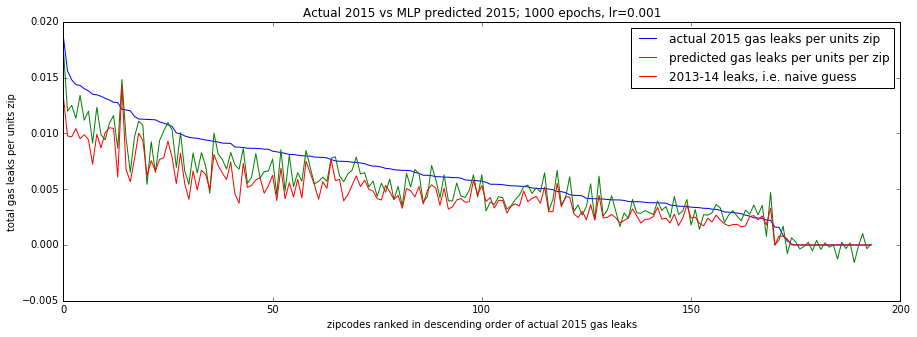

In [81]:
plot_mlp(model_1,epochs,learning)

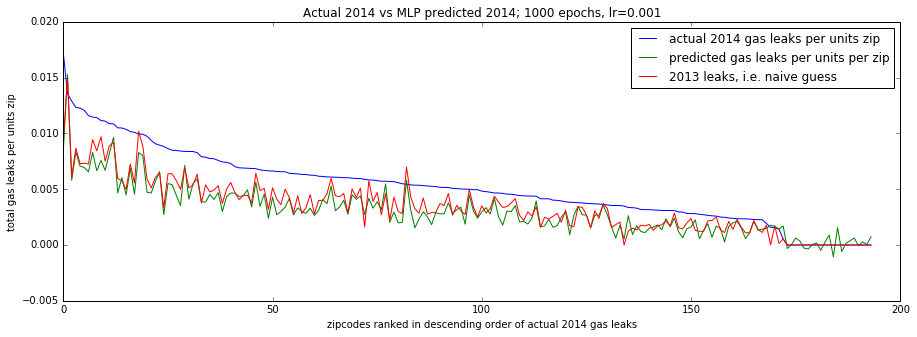

In [78]:
plot_mlp(model_2,epochs,learning)

2015 test with
- gamma:0.01
- activation function: tanh
- lr: 0.001
- hidden: 350 (0.0043 cross-validation was score to beat)
- seemed to find a consistent minimum around rmse 0.0044/0.0043

In [85]:
final_output = init_zip_2015.copy()
final_output = final_output[final_output.ZipCode!=0]
final_output['naive'] = (init_zip_2013[
    'gas_incidents_per_bldg_unit']+init_zip_2014[
    'gas_incidents_per_bldg_unit'])/2
final_output['yhat'] = model_1[0]

In [88]:
final_output.to_csv('djc_zip_baseline.csv',index=False)

In [89]:
model_1[-1]

(0.0046201909484505825, 0.0051557672782156861)